<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP_V09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP | Disciplina Machine Learning & Analytics - Modelo Deep Learning - Letra b.
Aluno: Sérgio Augusto Freitas Filho </br></br>

**Qual é a descrição do problema?**</br>
Para elaboração desse trabalho escolhi o DataSet da Amazon Cell Phones Reviews https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews. É uma base de avaliação de celulares, foi escolhida por questão didática para ilustrar um problema de classificação de texto e análise de sentimento. O dataset possui um conjunto de informações sobre as avaliações, como por exemplo: nome do avaliador, data, utilidade, body e rating. Para o escopo desse trabalho selecionamos 2 atributos do dataset: body e rating, sendo o body a avaliação do celular e o rating uma nota atribuída pelo avaliador que pode variar de 1 até 5, sendo 1 muito ruim e 5 excelente.</br>
**Você tem premissas ou hipóteses sobre o problema? Quais?** Neste problema, temos a hipótese de que as avaliações 1 e 2 são mais negativas, enquanto as avaliações 4 e 5 são mais positivas. Por isso, optamos por realizar a classificação categórica com 5 classes para avaliar os resultados, mas também implementamos a classificação binária para determinar se a avaliação é positiva ou negativa.
Ao longo do trabalho, testamos essa hipótese e constatamos que a classificação binária é mais adequada para resolver esse problema, considerando a diferenciação clara entre avaliações negativas e positivas.</br>

In [1]:
!pip install tensorflow-text

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import gdown
import zipfile
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text
import warnings
warnings.filterwarnings("ignore")

**##ATENÇÃO##** </BR>
As constantes CARGA_PESOS_MODELO_BIN e CARGA_PESOS_MODELO_MLT devem ser atribuídas "True" para acelerar a execução e evitar a necessidade de realizar todo treinamento.

In [3]:
CARGA_PESOS_MODELO_BIN = True   #Carrega os pesos e histórico de treinamento salvo previamente no google drive.
CARGA_PESOS_MODELO_MLT = True   #Carrega os pesos e histórico de treinamento salvo previamente no google drive.
#CARGA_PESOS_ZIP_URL_DRIVE = "https://drive.google.com/u/0/uc?id=1IZEbgA3kCAwLh5JfOdRgewcGibVPUTWC&export=download"
CARGA_PESOS_ZIP_URL_DRIVE = "https://drive.google.com/u/0/uc?id=1RVh7Q7_Debq_FNHi7dKssetPqfmmg3eJ&export=download"
ZIP_NAME_COLAB = 'pesos.zip'
PATH_PESOS_COLAB_FILE_BIN = '/content/bert_mvp/pesos_modelo_bin.h5'
PATH_PESOS_COLAB_FILE_MLT = '/content/bert_mvp/pesos_modelo_mlt.h5'
PATH_PESOS_COLAB_FOLDER = '/content/bert_mvp/'

In [4]:
#Cria pasta no COLAB
if os.path.exists(PATH_PESOS_COLAB_FOLDER):
  shutil.rmtree(PATH_PESOS_COLAB_FOLDER)

os.makedirs(PATH_PESOS_COLAB_FOLDER, exist_ok=True)

In [5]:
#Download dos dados de treinamento
if CARGA_PESOS_MODELO_BIN or CARGA_PESOS_MODELO_MLT:
  zip_file = PATH_PESOS_COLAB_FOLDER + ZIP_NAME_COLAB
  gdown.download(CARGA_PESOS_ZIP_URL_DRIVE, zip_file)

Downloading...
From: https://drive.google.com/u/0/uc?id=1RVh7Q7_Debq_FNHi7dKssetPqfmmg3eJ&export=download
To: /content/bert_mvp/pesos.zip
100%|██████████| 811M/811M [00:05<00:00, 155MB/s]


In [6]:
if CARGA_PESOS_MODELO_BIN or CARGA_PESOS_MODELO_MLT:
  # Abre o arquivo ZIP
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      # Extrai todo o conteúdo para a pasta de destino
      zip_ref.extractall(PATH_PESOS_COLAB_FOLDER)

# Importando DataSet Amazon Cell Phones Reviews
https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews</BR>
Vamos trabalhar com 2 instâncias do DataSet, em ambas selecionamos as features "body" e "rating" que correspondem ao texto de avaliação dos celulares e a nota de avaliação. No primeiro dataset(df_mult) utilizamos os dados originais com o target (nota de avaliação) variando de 1 até 5 e no segundo DataSet(df_bin) adaptamos o target para trasfomar o problema em uma classificação binária, conforme demonstrado na seção subsequente de Preparação e Pre-processamento dos dados.

In [7]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/20191226-reviews.csv"

# Lê o arquivo
df_mult = pd.read_csv(url, delimiter=',', encoding='latin-1')
df_bin = pd.read_csv(url, delimiter=',', encoding='latin-1')

df_bin.head(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


# Preparação e pre-processamento dos Dados
Realizamos algumas adequações nos dados antes de submeter para  pre-processamento e treinamento no BERT. O BERT já possui seu próprio processo de pré-processamento de texto, que envolve tokenização e embeddings de palavras. Portanto, o próprio BERT já incorpora a normalização e a padronização de texto por meio de seus embeddings. Não é necessário realizar essas etapas manualmente.
*   Selecionamos uma amostragem balanceada dos dados onde cada valor do target deverá possuir o mesmo número de amostras.
*   Utilizamos 3500 registros para cada valor do Target em ambos DataSets (Binário e Multiclasse)
*   Para o dataset utilizado na classificação binária vamos adaptar a coluna "rating" da seguinte forma: os valores 1 e 2 vão ser transformados em "0", os valores 4 e 5 serão convertidos em "1" e o valor 3 "None".
*   Remover as linhas que contêm valores ausentes (NaN)
*   Redefinir os índices do DataFrame após a remoção das linhas com valores ausentes.
*   Remove caracteres especiais não reconhecidos, usando encode e decode entre os padrões ASCII e UTF-8
*   Seleciona somente as colunas "Body" e "Rating" que vão ser parte do escopo do trabalho.
*   Utilizamos train_test_split da biblioteca do sklearn para separação dos DataSets em teste e treino, com 20% das amostras para teste e 80% para treino.

In [8]:
# Separar registros por valor do rating
grouped_bin = df_bin.groupby('rating')
grouped_mlt = df_mult.groupby('rating')

num_samples_per_rating = 3500 # Número desejado de registros de cada valor de rating
sampled_dfs_bin = []
sampled_dfs_mlt = []

# Percorre cada grupo, fazendo o sampling de registros de cada grupo
for rating, group in grouped_bin:
    sampled_group_bin = group.sample(n=num_samples_per_rating, random_state=42)
    sampled_dfs_bin.append(sampled_group_bin)

for rating, group in grouped_mlt:
    sampled_group_mlt = group.sample(n=num_samples_per_rating, random_state=42)
    sampled_dfs_mlt.append(sampled_group_mlt)

# Concatena os DataFrames amostrados em um único DataFrame final
df_bin = pd.concat(sampled_dfs_bin)
df_mult = pd.concat(sampled_dfs_mlt)

# Embaralha os registros no DataFrame resultante
df_bin = df_bin.sample(frac=1, random_state=42)
df_mult = df_mult.sample(frac=1, random_state=42)

In [9]:
#df_mult = df_mult.head(10000)
#df_bin = df_bin.head(10000)

In [10]:
mapping={1:0,2:0,3:None,4:1,5:1}
df_bin.rating=df_bin.rating.map(mapping)
df_bin=df_bin.dropna(subset='rating')

In [11]:
df_bin.head(100)

,asin,name,rating,date,verified,title,body,helpfulVotes
14052,B00OEK6TWU,christina,0.0,"April 21, 2017",True,I'd Recommend purchasing a phone from your car...,This phone freezes. It doesn't allow me to dow...,1.0
45737,B079SQ5VHX,Michael Royer,0.0,"November 6, 2018",True,Suspected LCD problem with galaxy s9.,Quite attracted to the product first hand. Qui...,9.0
33592,B06XZRH5ZC,Guillermo Ayala Alvarenga,0.0,"November 23, 2017",True,Worst phone EVER,Worst phone EVER! the wifi setting suddendly s...,2.0
21714,B01D0JV7AO,Anonymous,0.0,"September 6, 2016",True,Take your business to a different company,Save your money and never buy from this sham o...,372.0
8981,B00F9RRVUG,CJ_NY,1.0,"September 22, 2014",True,A perfectly functional phone,A great drop phone for those times you need to...,3.0
...,...,...,...,...,...,...,...,...
11450,B00KM10ITK,Jerome Romero,0.0,"August 4, 2015",True,Two Stars,Phone doesn't work,NaN
40512,B0766TPHSH,Lord_Theoden,0.0,"March 20, 2018",True,So far the phone is fine but not being able to...,I'm only giving this a 2 star because when I g...,4.0
41906,B0775451TT,Alexander Duff,1.0,"July 31, 2019",True,good,good,NaN
33802,B06Y16RL4W,Vic,1.0,"October 14, 2019",True,Wont work with Xfinity,Great Phone But if you want to use it with wit...,NaN


In [12]:
df_bin = df_bin[["body", "rating"]]
df_mult = df_mult[["body", "rating"]]
df_mult.loc[:, "rating"] = df_mult["rating"].astype(float)

In [13]:
df_mult = df_mult.dropna()
df_mult = df_mult.reset_index(drop=True)

df_bin = df_bin.dropna()
df_bin = df_bin.reset_index(drop=True)

In [14]:
rat_bin=df_bin.rating.value_counts()
rat_mult=df_mult.rating.value_counts()

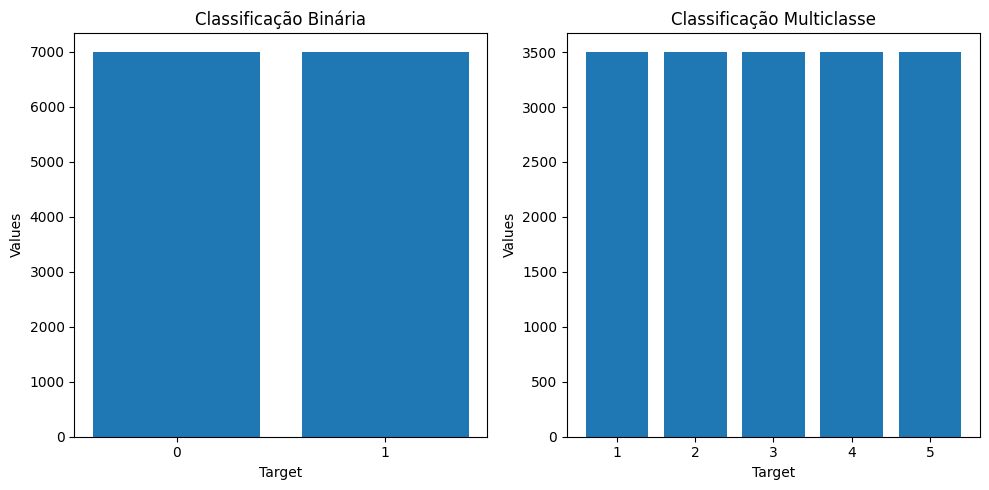

In [15]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_bin.index, rat_bin.values)
axes[0].set_xticks(rat_bin.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Classificação Binária')

# Plotagem do segundo gráfico
axes[1].bar(rat_mult.index, rat_mult.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Classificação Multiclasse')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [16]:
df_bin.loc[:, "body"] = df_bin["body"].str.encode("ascii", "ignore").str.decode("utf-8")
df_mult.loc[:, "body"] = df_mult["body"].str.encode("ascii", "ignore").str.decode("utf-8")

In [17]:
df_mult.head(10)

,body,rating
0,This phone freezes. It doesn't allow me to dow...,1.0
1,Ive had this phone for about 8 months now and ...,3.0
2,Quite attracted to the product first hand. Qui...,2.0
3,"Although this phone looks good, there are cert...",3.0
4,Worst phone EVER! the wifi setting suddendly s...,1.0
5,Save your money and never buy from this sham o...,1.0
6,A great drop phone for those times you need to...,4.0
7,This has been the worst phone I've ever owned....,1.0
8,"I really loved this phone at first, but I only...",3.0
9,THE PHONE IS SUPPOSED TO BE UNLOCKED PHONE. UN...,2.0


**Separação em base de treino e teste**, não achamos necessário trabalhar com conjunto de validação.

In [18]:
# Separação em base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_bin.body,df_bin.rating,test_size=0.2)
R_train, R_test, t_train, t_test = train_test_split(df_mult.body,df_mult.rating,test_size=0.2)

# Definição do Modelo e Treinamento
Optei por trabalhar com a arquitetura do BERT (Bidirectional Encoder Representations from Transformers), que é um poderoso modelo pré-treinado para o processamento de linguagem natural. O BERT é capaz de capturar relações semânticas complexas entre palavras em um texto, e seu desempenho tem sido muito bem-sucedido em várias tarefas de processamento de linguagem natural, incluindo classificação de texto. Sendo assim entendo o modelo como sendo adequado para resolver o problema de classificação de texto e realizar a predição da avaliação como positiva ou negativa. </br>

**No código abaixo definimos duas camadas do modelo BERT (Bidirectional Encoder Representations from Transformers) usando o TensorFlow Hub. Vamos analisar cada uma dessas camadas:**

**bert_preprocess:** Essa camada do TensorFlow Hub realiza o pré-processamento dos dados de texto para o formato que o modelo BERT espera como entrada. O BERT requer uma tokenização específica e o mapeamento dos tokens para os índices do vocabulário do BERT. O modelo "bert_en_uncased_preprocess/3" é uma versão específica do BERT que foi pré-treinada em texto em inglês e é case-insensitive (não diferencia maiúsculas de minúsculas). Essa camada é responsável por transformar os textos brutos em tensores que podem ser usados como entrada para o BERT.

**bert_encoder:** Essa camada do TensorFlow Hub carrega a arquitetura do modelo BERT pré-treinado. O modelo "bert_en_uncased_L-12_H-768_A-12/4" é uma versão específica do BERT com 12 camadas de codificador, 768 dimensões de embeddings ocultos e 12 cabeças de atenção (multi-head attention). Ele é pré-treinado em um grande corpus de texto em inglês e é capaz de aprender representações ricas de palavras que capturam o contexto semântico das frases.

In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

## Ações para melhoria da Performance do Modelo e Otimização dos Hiperparametros
Na busca por melhorar a performance dos modelos realizamos algumas ações com o objetivo de otimização de Hiperparametro. Uma tentativa foi a utilização do otimizador AdamW que possui uma taxa de aprendizado adaptativa mas não houve melhora nos resultados. Outra tentativa foi a manipulação do dropout. Também não obtivemos êxito. A melhoria dos resultados foi obtida primordialmente com ações diretas no dataset, como: removendo caracteres não desejados, eliminando linhas em branco, balanceando a amostra dos dados  e finalmente, alcançamos o resultado de acurácia de 0.81 considerando a classificação binária optando por capturar somente o sentimento da avaliação como positivo ou negativo.

##Definição dos Modelos BERT para Classificação Binária e Categórico
Primeiro definimos o modelo de classificação binário, onde o texto de entrada passa por uma camada de pré-processamento do BERT, resultando em uma representação numérica. Em seguida, uma camada de dropout com taxa de 0.001 é aplicada para evitar overfitting durante o treinamento. Após o dropout, é adicionada uma camada densa de saída com ativação sigmoid, permitindo que o modelo classifique as avaliações como positivas ou negativas.

Segundo definimos

In [20]:
#Definição do modelo de classificação binária utilizando a arquitetura do modelo BERT.
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.001,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
model_bin=tf.keras.Model(inputs=[text_input],outputs=[l])


#Alterado para considerar as 5 classses e ativação softmax
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.001,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model_mult=tf.keras.Model(inputs=[text_input],outputs=[l])

In [21]:
#model_bin.summary()

In [22]:
METRICS_BIN=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_MULT=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

model_mult.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS_MULT)
model_bin.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=METRICS_BIN)
#model_mult.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS_MULT)
#model_bin.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS_BIN)

In [23]:
if CARGA_PESOS_MODELO_BIN:
  model_bin.load_weights(PATH_PESOS_COLAB_FILE_BIN) #Carrega os pesos do modelo
  history = keras.callbacks.History()
  path = PATH_PESOS_COLAB_FOLDER + 'history_bin.pkl'
  with open(path, 'rb') as f:
    history.history = pickle.load(f)
else:
  history = model_bin.fit(X_train,y_train,epochs=10)
  model_bin.save_weights(PATH_PESOS_COLAB_FILE_BIN) #Salva os pesos do modelo
  # Salvar o histórico de treinamento
  path = PATH_PESOS_COLAB_FOLDER + 'history_bin.pkl'
  with open(path, 'wb') as f:
      pickle.dump(history.history, f)

In [24]:
if CARGA_PESOS_MODELO_MLT:
  model_mult.load_weights(PATH_PESOS_COLAB_FILE_MLT) #Carrega os pesos do modelo
  history_mult = keras.callbacks.History()
  path = PATH_PESOS_COLAB_FOLDER + 'history_mlt.pkl'
  with open(path, 'rb') as f:
    history_mult.history = pickle.load(f)
else:
  #Converta os rótulos de classe em codificação one-hot
  t_train_adjusted = t_train - 1
  t_train_one_hot = tf.keras.utils.to_categorical(t_train_adjusted, num_classes=5)
  #Treinamento do modelo com 5 classes
  history_mult = model_mult.fit(R_train,t_train_one_hot,epochs=10)
  model_mult.save_weights(PATH_PESOS_COLAB_FILE_MLT) #Salva os pesos do modelo
  # Salvar o histórico de treinamento
  path = PATH_PESOS_COLAB_FOLDER + 'history_mlt.pkl'
  with open(path, 'wb') as f:
      pickle.dump(history_mult.history, f)

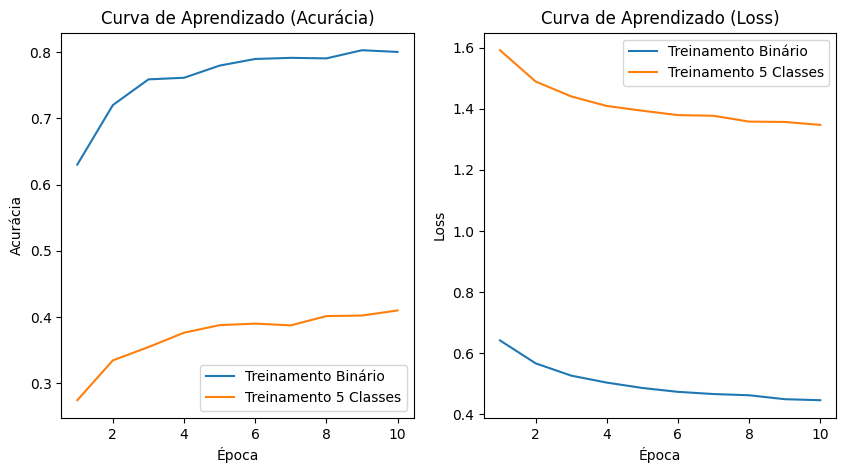

In [25]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Obtendo os scores de treinamento do histórico
train_scores_mult = history_mult.history['accuracy']
train_scores = history.history['accuracy']

# Obtendo os valores de Loss do histórico
train_loss = history.history['loss']
train_loss_mult = history_mult.history['loss']

# Plotando a curva de aprendizado
axes[0].plot(range(1, 11), train_scores, label='Treinamento Binário')
axes[0].plot(range(1, 11), train_scores_mult, label='Treinamento 5 Classes')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Aprendizado (Acurácia)')
axes[0].legend()


# Plotando a curva de aprendizado
axes[1].plot(range(1, 11), train_loss, label='Treinamento Binário')
axes[1].plot(range(1, 11), train_loss_mult, label='Treinamento 5 Classes')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].set_title('Curva de Aprendizado (Loss)')
axes[1].legend()

plt.show()


## Avaliando a performance dos modelos com a base de teste

In [26]:
model_bin.evaluate(X_test,y_test)

88/88 [==============================] - 28s 304ms/step - loss: 0.4369 - accuracy: 0.8014 - precision: 0.7719 - recall: 0.8614


[0.436852365732193, 0.801357626914978, 0.7718631029129028, 0.8613861203193665]

In [27]:
#Converte os rótulos de classe em codificação one-hot, transforma variável categórica em vetores binários de dimensão igual ao número de classes.
t_test_adjusted = t_test - 1
t_test_one_hot = tf.keras.utils.to_categorical(t_test_adjusted, num_classes=5)
model_mult.evaluate(R_test,t_test_one_hot)

110/110 [==============================] - 35s 314ms/step - loss: 1.3329 - accuracy: 0.4033 - precision: 0.6754 - recall: 0.0815


[1.3328555822372437,
 0.4032580852508545,
 0.6753554344177246,
 0.08145184069871902]

#Utiliza os modelos para predição

In [28]:
#Realiza predição para base de teste utilizando o modelo de classificação binário .
y_pred=model_bin.predict(X_test)
y_pred=y_pred.flatten() #converte em vetor unidimensional para comparadar com o vetor de rótulos reais

88/88 [==============================] - 29s 319ms/step


In [29]:
#Realiza predição para base de teste utilizando o modelo de classificação categórico .
t_pred=model_mult.predict(R_test)
t_pred_classes = np.argmax(t_pred, axis=1) #Obtém as classes previstas a partir das probabilidades preditas
print(t_pred_classes)

110/110 [==============================] - 35s 311ms/step
[2 2 2 ... 0 2 2]


In [30]:
# Imprime os valores únicos somente para certificar o domínio
t_test = t_test -1
array = t_test.values
unique_values = np.unique(array)
print(unique_values)

[0. 1. 2. 3. 4.]


In [31]:
# Imprime os valores únicos somente para certificar o domínio
unique_values = np.unique(t_pred_classes)
print(unique_values)

[0 1 2 3 4]


In [32]:
#y_pred=np.where(y_pred>0.5,1,0)
#y_pred

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
#import seaborn as sns
#from IPython.display import display, HTML

In [34]:
cm=confusion_matrix(y_test,y_pred)
cm_mult=confusion_matrix(t_test,t_pred_classes)

# Criação da figura e dos dois subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotagem da primeira matriz de confusão no primeiro subplot
sns.heatmap(cm_mult, annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Truth")
axs[0].set_title("Matriz de Confusão Multiclasse")

# Plotagem da segunda matriz de confusão no segundo subplot
sns.heatmap(cm, annot=True, fmt='d', ax=axs[1])
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Truth")
axs[1].set_title("Matriz de Confusão Binária")

# Ajuste do layout para evitar sobreposição de rótulos e títulos
plt.tight_layout()

# Mostrar a figura com os subplots lado a lado
plt.show()

print("\n\n")  # Espaçamento (pular linha)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir o valor da AUC
print('Área sob a curva (AUC):', roc_auc)

ValueError: ignored

In [ ]:
print(classification_report(t_test,t_pred_classes,zero_division=1))

In [ ]:
print(classification_report(y_test,y_pred))